# Analytical hertz solutions
It is often useful to have analytical hertz solutions to hand when solving tribology problems. Slippy contains hertz solvers for tackling different types of problems. These are:

- solve\_hertz\_line and solve\_hertz\_point provide a basic solver which will find the remaining parameter given an incomplete set
- hertz\_full provides a much more detailed set of results including functions for sub surface stresses in the bodies

These three functions are found in the contact sub package:

In [1]:
%matplotlib inline
import numpy as np
import slippy.contact as c

## solve\_hertz\_point
solve\_hertz\_point is used to find the remaining parameter given a set of parameters for point contacts. For example it can find the load needed for a particular maximum pressure etc. given a geometry and set of materials. It cannot be used when there is an angle between the principal radii of the contacting bodies.

In the example below we will find the necessary normal load to induce a given maximum pressure for a given contact set of materials and contact geometry. Here the r_rel parameter is the combined radius of the bodies:

$r_{rel} = \left(\frac{1}{r_1}+\frac{1}{r_2}\right)^{-1}$

For a ball on flat contact this is simply the radius of the ball.

In [2]:
result = c.solve_hertz_point(r_rel = 0.01, e1 = 200e9, e2 = 70e9, v1=0.3, v2=0.33, 
                             max_pressure = 1e9)

The result is a named tuple with all of the avalible parameters found and filled in. You can list all of the found parameters as follows:

In [3]:
print("The required load is: ", result.load)
print(list(result._asdict().keys()))

The required load is:  154.30707677824725
['r_rel', 'e1', 'e2', 'v1', 'v2', 'load', 'e_star', 'contact_radius', 'max_pressure', 'max_tensile_stress', 'max_shear_stress', 'max_von_mises', 'total_displacement']


solve\_hertz\_line works in a similar way.

# Hertz Full
Hertz full is a much more detailed solver, it provides many useful values and functions. The actual values which are provided depend on the contact solved as analytical solutions are not avalibe for all contacts. To use hertz full we need to provide the material properties, geometry of the bodies and the total normal load.

The following code solves the contact given above:

In [4]:
full_results = c.hertz_full(r1 = 0.01, r2 = float('inf'), moduli=[200e9, 70e9], v=[0.3, 0.33],
                            load = result.load)
print(list(full_results.keys()))

['alpha', 'beta', 'relative_radii', 'r_e', 'e_star', 'contact_shape', 'contact_radii', 'contact_area', 'mean_pressure', 'total_deflection', 'max_pressure', 'surface_displacement_b_f', 'pressure_f', 'max_tensile_stress_b', 'stress_z_axis_b_f', 'stress_surface_axis_b_f', 'max_shear_stress_b', 'max_shear_depth_b']


As shown we have a lot of results avalible to us. The majority of these are single values and have explanitory names in the dictionary. 

Parameters with a '\_b' suffix are quantities which are different for each body. They are two element lists with the first values relating to the first body (r1, and the first value for the material properties).

Parameters with a '\_f' suffix are functions which give the parameters when supplied an array of coordinate locations.

In the following example we will reproduce the famous graph of the subsurface stresses below the centre of the spherical contact. Note that we use the first function so we are plotting for the first body, the sub surface stresses in the sceond body will be different.

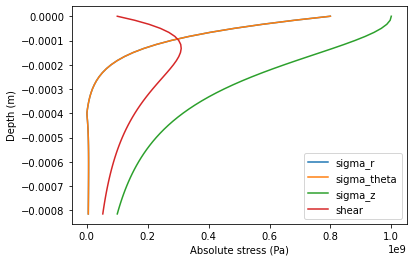

In [5]:
import matplotlib.pyplot as plt
z = np.linspace(1e-8, full_results['contact_radii'][0]*3)
stress_results = full_results['stress_z_axis_b_f'][0](z)
for label, array in stress_results.items():
    plt.plot(np.abs(array), -z, label = label)
shear = 0.5*np.abs(stress_results['sigma_z']-stress_results['sigma_theta'])
plt.plot(shear, -z, label = 'shear')
plt.legend()
plt.xlabel('Absolute stress (Pa)')
_ = plt.ylabel('Depth (m)')

We can also create plots of the surface stresses, contact pressure and displacement of either surface. These functions are interesting in themselves but they also provide a simple way to make comparisons with numerical data or intialise solutions to iterative solvers.

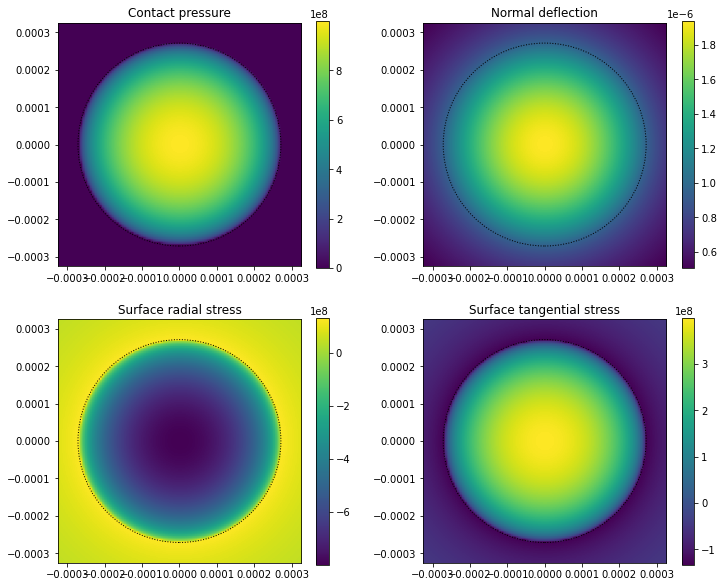

In [6]:
contact_radius = full_results['contact_radii'][0]
extent = [-contact_radius*1.2, contact_radius*1.2]
x, y = np.meshgrid(*[np.linspace(*extent, 100)]*2)
extent*=2
r = np.sqrt(x**2+y**2)
fig, axes = plt.subplots(2,2, figsize = (12,10))
deflection = full_results['surface_displacement_b_f'][0](r)
images = []
images.append(axes[0][0].imshow(full_results['pressure_f'](r), extent = extent))
images.append(axes[0][1].imshow(deflection['uz'], extent=extent))

surface_stresses = full_results['stress_surface_axis_b_f'][0](r)
images.append(axes[1][0].imshow(surface_stresses['sigma_r'], extent = extent))
images.append(axes[1][1].imshow(surface_stresses['sigma_theta'], extent=extent))

circles = [plt.Circle((0,0), radius = contact_radius, fill=False, ls=':') for i in range(4)]
titles = ['Contact pressure','Normal deflection',
          'Surface radial stress','Surface tangential stress']
for i in range(4):
    ax = axes.flatten()[i]
    ax.set_title(titles[i])
    fig.colorbar(images[i], ax=ax)
    ax.add_artist(circles[i])

# Other contact shapes
Hertz full also provides support for elepitical and line contacts. But note that if you want to solve a line contact this must be explicitly declared by passing the line kwyword argument to the function. This is becuase for a line contct the load is ginven per unit length where as for other contacts the load is the total load.